# 1. 定義、導入模型

In [11]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pretty_midi
import os
import torch.nn.functional as F

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_PATH = "../model/best_model.pth" 

print(f"Device: {DEVICE}")

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.LeakyReLU(0.1)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        return self.relu(out)

class SelfAttention(nn.Module):
    def __init__(self, hidden_size):
        super(SelfAttention, self).__init__()
        self.projection = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, encoder_outputs):
        energy = self.projection(encoder_outputs)
        weights = F.softmax(energy.squeeze(-1), dim=1)
        outputs = torch.bmm(weights.unsqueeze(1), encoder_outputs)
        return outputs.squeeze(1)

class MusicCritic(nn.Module):
    def __init__(self):
        super().__init__()

        self.entry = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(5,5), padding=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d((2,1))
        )

        self.res_blocks = nn.Sequential(
            ResidualBlock(64),
            nn.MaxPool2d((2,1)),
            ResidualBlock(64),
            nn.MaxPool2d((2,1)),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d((2,1))
        )

        self.rnn = nn.LSTM(640, 256, num_layers=2, batch_first=True, bidirectional=True, dropout=0.3)
        self.attention = SelfAttention(256 * 2)
        self.clf = nn.Sequential(
            nn.Linear(512, 128), nn.LeakyReLU(0.1), nn.Dropout(0.4),
            nn.Linear(128, 1), nn.Sigmoid()
        )

    def forward(self, x):
        x = self.entry(x)
        x = self.res_blocks(x)

        x = x.permute(0, 3, 1, 2)
        B, T, C, H = x.shape
        x = x.reshape(B, T, C * H)

        r_out, _ = self.rnn(x)
        ctx = self.attention(r_out)
        return self.clf(ctx)

# --- 載入模型 ---
if not os.path.exists(MODEL_PATH):
    print(f"❌ 找不到模型: {MODEL_PATH}")
    print("請確認路徑，或手動上傳 best_model.pth")
else:
    model = MusicCritic().to(DEVICE)
    # map_location 確保在 CPU 也能跑
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.eval()
    print("模型載入成功")

Device: cpu
模型載入成功


# 2. 生成音樂

🎹 開始生成... (時長: 10秒, 每秒音數: 3)


  0%|          | 0/10 [00:00<?, ?it/s]

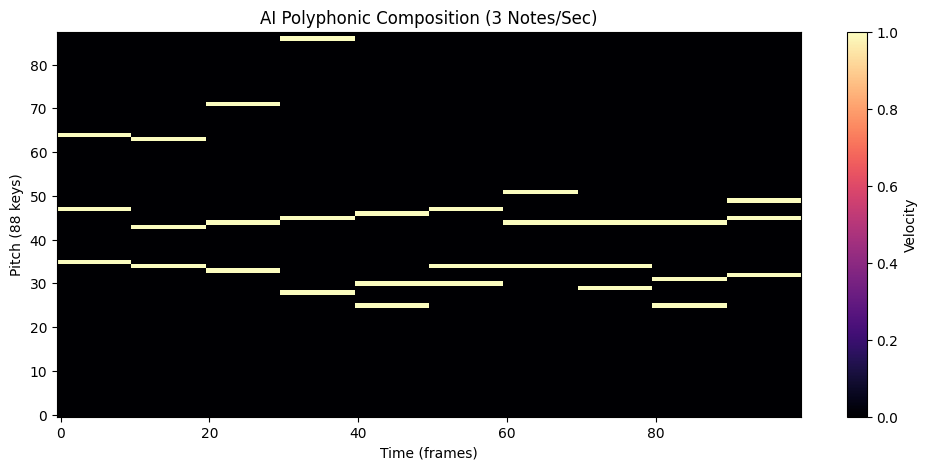

In [ ]:
from tqdm.notebook import tqdm

def generate_polyphonic(model, duration_sec=10, fs=10, notes_per_sec=3, top_k=3):
    total_frames = duration_sec * fs
    canvas = torch.zeros(1, 1, 88, total_frames).to(DEVICE)
    note_duration = fs 
    
    print(f"開始生成... (時長: {duration_sec}秒, 每秒音數: {notes_per_sec})")
    
    for second in tqdm(range(duration_sec)):
        start_frame = second * fs
        end_frame = start_frame + note_duration
        
        for layer in range(notes_per_sec):
            
            # 1. 複製當前畫布 88 份
            candidates = canvas.repeat(88, 1, 1, 1)
            
            # 2. 試探：在當前基礎上，疊加每一個可能的音
            for pitch in range(88):
                # 如果這個音已經被選過了，就不再選 (避免同一個鍵按兩次)
                # 我們把對應位置設為 1.0 (疊加)
                candidates[pitch, 0, pitch, start_frame:end_frame] = 1.0
            
            # 3. 批量打分
            with torch.no_grad():
                scores = model(candidates).flatten()
            
            # 4. 避免重複選音：
            # 獲取當前已經被選中的音 (值為1的)
            current_notes = torch.where(canvas[0, 0, :, start_frame] > 0.5)[0]
            # 把這些已經存在的音的分數設為 -無窮大，確保不會再被選中
            scores[current_notes] = -float('inf')
            
            # 5. Top-K 採樣
            # 如果是第1個音，我們用 Top-K 隨機性大一點
            # 如果是第2、3個音（和聲），我們希望它配合得好一點，也可以保持 Top-K
            k = top_k
            top_scores, top_indices = torch.topk(scores, k)
            
            # 轉 numpy 隨機選
            chosen_i = np.random.randint(0, k)
            best_pitch_idx = top_indices[chosen_i].item()
            score_val = top_scores[chosen_i].item()
            
            # 6. 落子 (更新畫布)
            canvas[0, 0, best_pitch_idx, start_frame:end_frame] = 1.0

    return canvas.squeeze().cpu().numpy()

generated_roll = generate_polyphonic(model, notes_per_sec=3, top_k=3)

plt.figure(figsize=(12, 5))
plt.imshow(generated_roll, aspect='auto', origin='lower', cmap='magma', interpolation='nearest')
plt.title("AI Polyphonic Composition (3 Notes/Sec)")
plt.ylabel("Pitch (88 keys)")
plt.xlabel("Time (frames)")
plt.colorbar(label="Velocity")
plt.show()

# 3. 導出 MIDI 檔案

In [25]:
def matrix_to_midi(pianoroll, output_filename="ai_composition.mid", fs=10):
    pm = pretty_midi.PrettyMIDI()
    piano = pretty_midi.Instrument(program=0) # Piano
    
    h, w = pianoroll.shape
    frame_duration = 1.0 / fs
    
    # 掃描每一秒
    for t in range(0, w, 10): # 步長10帧 (1秒)
        # 取出這一秒的切片
        segment = pianoroll[:, t:t+10]
        
        # 找出所有被激活的音高 (平均力度 > 0.5)
        # sum(axis=1) 是把這10幀的能量加起來，如果大於 5.0 (即大半時間都是1)，就算有音
        note_energies = segment.sum(axis=1)
        active_pitches = np.where(note_energies > 5.0)[0]
        
        for pitch_idx in active_pitches:
            note = pretty_midi.Note(
                velocity=100,
                pitch=pitch_idx + 21, # 加上偏移量 (A0=21)
                start=t * frame_duration,
                end=(t + 10) * frame_duration
            )
            piano.notes.append(note)
            
    pm.instruments.append(piano)
    pm.write(output_filename)
    print(f"已保存至: {output_filename}")

matrix_to_midi(generated_roll, output_filename="../figure/ai_composition.mid")

已保存至: ../figure/ai_composition.mid
